#### Experiments to demonstrate that weights evolve via D4 when given noise without signal.

The weights of a neural network will shift according to D4(x) := d^x/dx^2 (s(x)*(d/dt s(x))) when the network computes activations using sigmoidal nonlinear function s(x) such as tanh. This is a result of combination of weights that experience a noisy error signal and the curvature of D2 (see signal-follows-D2). To support this claim, this notebook runs a tiny experiment that compares analytic predictions of the theory with observed reality.

To simplify the analysis without a loss of generality, we substitute changing weights with changing weights-divided-by-x-value, dubbed v or v_i. 
We calculate the gradient signal received by a vi, i.e. the gradient signal received by 'weight mod x_j input', which only vertically scales our results and thus isn't important to our questions of whether weights follow D2 or not. A tensorflow network is run under different sources of noise, such as data-driven noise, discretized algorithm noise, or broken symmetry of weights noise (see info.txt for more details), run in both minimally-simple cases and in more realistic cases.
Changes in weights are collected into a graph do determine if the analytic prediction (noise follows D4) matches up with the observed reality (how does a weight mod x change under noisy backprop).

#### Results:
Based on even just the simple cases data={(x,y),(x,-y)}, it seems my analysis was a little off. Instead of expected D4(x) = d^2/dx^2 D2(x), it seems that D4(x) = D2(x) * d/dx D2(x). Empirically, the numbers add up. D4(x) and D2(x) thus have the same functional relationship that D2(x) and s(x) have. These new D4 have the same basic shape that original D4 had, but it plays nicer with other functions too. Interesting.

New points to note, now:
- for all sigmoidals, beta == gamma. Alpha is drawn closer to 0. 
- for x/(1+|x|)==softsign and exp* == {odd extension of 1-e^-x,x>0}, delta/beta == beta/alpha. 
    softsign ratio: 0.3873; exp* ratio: 0.495.
- softsign alpha/beta/delta: l=[1.0083, .6585, 0.2934].
- tanh a/b/d: l=[1.0083, .6585, 0.2934]
- erf: [.9388, .6201, .2879]
- exp*: [1.1881, 0.6931, 0.1982]
- arctan: [1.1997, 0.7654, 0.3056]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime as dt
import numpy as np
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from math import erf

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-qj0zfbdp because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


Manually create D2 and D4 functions for analytic predictions:

In [3]:
def tanh(x): return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
def d2_tanh(x,y=0): return -(y-tanh(x))*(1-tanh(x)**2) 
def sech(x): return 2/(np.exp(x)+np.exp(-x))
def d4_tanh__(x,y=0): return -2*sech(x)**2*tanh(x) - 6*sech(x)**4*tanh(x) + 6*sech(x)**2*tanh(x)**3
def d4_tanh(x,y=0): return -2*sech(x)**4 *(y- 3*tanh(x)) + 2*sech(x)**2*tanh(x)*(1+2*y*tanh(x)-3*tanh(x)**2)

Experiment varieties:
- test effects of data-based 
 - basic cases: { (x,y),(x,-y) }, { (x,y),(1-x,y) }, 
 - randomly-generated, MNIST(?), hierarchical?, MNIST plus irrelevant data, MNIST plus extra copies of some data

- test effects of the discreteness of a neural network
 - batchsize: 1,2,32,N=|x|
 - learning rate
 - hyperparameter weights: set to uniform spread, set randomly / unif, gaussian / variance=0.1,0.3,1,3,...

- hyperparameter timesteps: 1, 1000, [until error reached w/ timeout]
- hyperparameter: change one weight at a time, change weights together / do once, do many times before eval

- hyperparameter: serial/parallel - apply gradients or not to basic cases?
- broken symmetry: plot total absolute weight change over error or change in error as network saturates

In [6]:
'y' if 33%2 else 'n'

'y'

In [419]:
def Set_weights(layer, weights):
#     weights_=np.array(weights)[np.newaxis,:]
#     print(weights_)
#     x=[weights.T]
#     print(x)
# #     print(x.shape)
    layer.set_weights([np.expand_dims(weights,0)])
    
# initialize a network 
def init_manual_model(nonlinearity, weight_value=np.zeros((1,)), learning_rate=0.01):
    assert type(weight_value)==type(np.array((1,)))
    nonlinearity_name, nonlinearity_function=nonlinearity
    model = Sequential()
    try:
        model.add(
            Dense(
                1, # num output units
                kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
                input_shape=(1,),
                activation=nonlinearity_name,
                use_bias=False,
            )
        )
    except: 
        model.add(
            Dense(
                1, # num output units
                kernel_initializer=tf.keras.initializers.zeros(),   #  placeholder
                input_shape=(1,),
                activation=nonlinearity,
                use_bias=False,
            )
        )
    model.compile(
        loss=tf.keras.losses.mean_squared_error,
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
    )
    Set_weights(model.layers[0], weight_value)
    return model



### expt 1 - most basic case possible. 
How do weights change in isolation under data-label noise? 

In [183]:
Nonlinearity = ('tanh', tanh)
def weights_range(min_=-3, max_=3, spacing=101): # 1/spacing is interval size
    spc=spacing*(max_-min_)
    if (spc%2==0): spc+=1
    return np.linspace(min_, max_, spc), (min_,max_)
Weights, bounds = weights_range(-4,4,20)
Y_data = [1,1,-1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
N_trials = 6
Weights[:10]

array([-4.  , -3.95, -3.9 , -3.85, -3.8 , -3.75, -3.7 , -3.65, -3.6 ,
       -3.55])

In [290]:
# test
test_model_init=init_manual_model(Nonlinearity, Weights[0:1])
print(test_model_init.layers[0].get_weights())

def query_manual_model_wrapper(n_epochs=1, batchsize=len(Y_data)):

    weights_inbox = []
    changes_inbox = []
    weights_to_changes = []  # tuple of indices counter-coords then data (weight, change)
    
    model=init_manual_model(Nonlinearity)

    weights_retreiver = LambdaCallback( 
            on_epoch_begin=lambda batch, logs: weights_inbox.append( model.layers[0].get_weights()[0]))
    changes_retriever = LambdaCallback( 
            on_epoch_end  =lambda batch, logs: changes_inbox.append( model.layers[0].get_weights()[0]))        

    for trial_counter in range(N_trials):
        Set_weights(model.layers[0], Weights[0:1])
        for weight_counter in range(Weights.shape[0]):
            Set_weights(model.layers[0], Weights[weight_counter:weight_counter+1])
            model.fit(
                np.array(X_data),  
                np.array(Y_data),
                batch_size=batchsize,
                epochs=n_epochs,
                callbacks=[weights_retreiver, changes_retriever], 
                verbose=0
            )
            change = changes_inbox[-1]-weights_inbox[-1]
            weights_to_changes.append( (trial_counter, weights_inbox[-1][0][0], change[0][0]) )
            if weight_counter % min(25,int(Weights.shape[0]/10)) == 0:
                print('trial '+str(trial_counter+1)+'/'+str(N_trials)+', iter '+
                              str(weight_counter)+' of '+str(Weights.shape[0]))
    print('done')
    return weights_to_changes
    
#wtc=query_manual_model_wrapper()
print(wtc[:5])


[array([[-2.]], dtype=float32)]
[(0, -2.0, 0.0027241707), (0, -1.9, 0.003273487), (0, -1.8, 0.0039201975), (0, -1.7, 0.0046744347), (0, -1.6, 0.0055470467)]


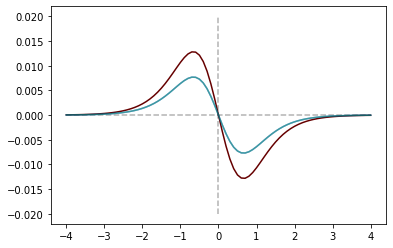

In [201]:
def plot_wtc(wtc=wtc,normz=False):
    shift=0.05
    # plt.plot([0,0], [0-0.02,shift+0.01], '--', color=[0,0,0,0.3])
    plt.plot([0,0], [-0.02,0.02], '--', color=[0,0,0,0.3])
    plt.plot(bounds, [0,0], '--', color=[0,0,0,0.3])
    # plt.plot(bounds, [shift, shift], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==0], 
             [d2_tanh(w[1])/-30+0*shift for w in wtc if w[0]==0],
             color=[0.4,0,0])
    for trial_counter in range(N_trials):
        plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-50 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])



plot_wtc()

trial 0/4, iter 0 of 81
trial 0/4, iter 8 of 81
trial 0/4, iter 16 of 81
trial 0/4, iter 24 of 81
trial 0/4, iter 32 of 81
trial 0/4, iter 40 of 81
trial 0/4, iter 48 of 81
trial 0/4, iter 56 of 81
trial 0/4, iter 64 of 81
trial 0/4, iter 72 of 81
trial 0/4, iter 80 of 81
trial 1/4, iter 0 of 81
trial 1/4, iter 8 of 81
trial 1/4, iter 16 of 81
trial 1/4, iter 24 of 81
trial 1/4, iter 32 of 81
trial 1/4, iter 40 of 81
trial 1/4, iter 48 of 81
trial 1/4, iter 56 of 81
trial 1/4, iter 64 of 81
trial 1/4, iter 72 of 81
trial 1/4, iter 80 of 81
trial 2/4, iter 0 of 81
trial 2/4, iter 8 of 81
trial 2/4, iter 16 of 81
trial 2/4, iter 24 of 81
trial 2/4, iter 32 of 81
trial 2/4, iter 40 of 81
trial 2/4, iter 48 of 81
trial 2/4, iter 56 of 81
trial 2/4, iter 64 of 81
trial 2/4, iter 72 of 81
trial 2/4, iter 80 of 81
trial 3/4, iter 0 of 81
trial 3/4, iter 8 of 81
trial 3/4, iter 16 of 81
trial 3/4, iter 24 of 81
trial 3/4, iter 32 of 81
trial 3/4, iter 40 of 81
trial 3/4, iter 48 of 81
trial 3/

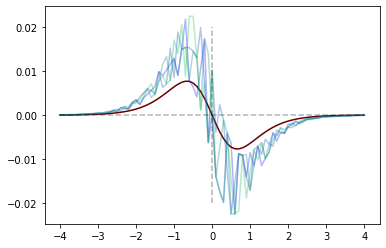

In [164]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-4,4,10)
N_trials = 4
wtc_alt=query_manual_model_wrapper()
plot_wtc(wtc_alt)

trial 0/(0..3), iter 0 of 81
trial 0/(0..3), iter 4 of 81
trial 0/(0..3), iter 8 of 81
trial 0/(0..3), iter 12 of 81
trial 0/(0..3), iter 16 of 81
trial 0/(0..3), iter 20 of 81
trial 0/(0..3), iter 24 of 81
trial 0/(0..3), iter 28 of 81
trial 0/(0..3), iter 32 of 81
trial 0/(0..3), iter 36 of 81
trial 0/(0..3), iter 40 of 81
trial 0/(0..3), iter 44 of 81
trial 0/(0..3), iter 48 of 81
trial 0/(0..3), iter 52 of 81
trial 0/(0..3), iter 56 of 81
trial 0/(0..3), iter 60 of 81
trial 0/(0..3), iter 64 of 81
trial 0/(0..3), iter 68 of 81
trial 0/(0..3), iter 72 of 81
trial 0/(0..3), iter 76 of 81
trial 0/(0..3), iter 80 of 81
trial 1/(0..3), iter 0 of 81
trial 1/(0..3), iter 4 of 81
trial 1/(0..3), iter 8 of 81
trial 1/(0..3), iter 12 of 81
trial 1/(0..3), iter 16 of 81
trial 1/(0..3), iter 20 of 81
trial 1/(0..3), iter 24 of 81
trial 1/(0..3), iter 28 of 81
trial 1/(0..3), iter 32 of 81
trial 1/(0..3), iter 36 of 81
trial 1/(0..3), iter 40 of 81
trial 1/(0..3), iter 44 of 81
trial 1/(0..3), 

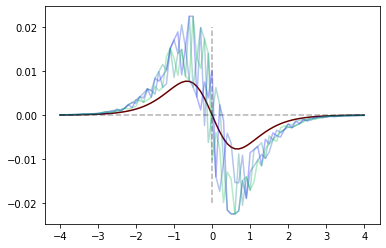

In [166]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-4,4,10)
N_trials = 4
wtc_alt=query_manual_model_wrapper()
plot_wtc(wtc_alt)

trial 0/2, iter 0 of 401
trial 0/2, iter 22 of 401
trial 0/2, iter 44 of 401
trial 0/2, iter 66 of 401
trial 0/2, iter 88 of 401
trial 0/2, iter 110 of 401
trial 0/2, iter 132 of 401
trial 0/2, iter 154 of 401
trial 0/2, iter 176 of 401
trial 0/2, iter 198 of 401
trial 0/2, iter 220 of 401
trial 0/2, iter 242 of 401
trial 0/2, iter 264 of 401
trial 0/2, iter 286 of 401
trial 0/2, iter 308 of 401
trial 0/2, iter 330 of 401
trial 0/2, iter 352 of 401
trial 0/2, iter 374 of 401
trial 0/2, iter 396 of 401
trial 1/2, iter 0 of 401
trial 1/2, iter 22 of 401
trial 1/2, iter 44 of 401
trial 1/2, iter 66 of 401
trial 1/2, iter 88 of 401
trial 1/2, iter 110 of 401
trial 1/2, iter 132 of 401
trial 1/2, iter 154 of 401
trial 1/2, iter 176 of 401
trial 1/2, iter 198 of 401
trial 1/2, iter 220 of 401
trial 1/2, iter 242 of 401
trial 1/2, iter 264 of 401
trial 1/2, iter 286 of 401
trial 1/2, iter 308 of 401
trial 1/2, iter 330 of 401
trial 1/2, iter 352 of 401
trial 1/2, iter 374 of 401
trial 1/2, it

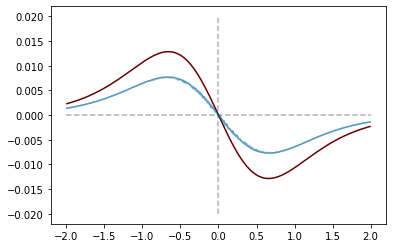

In [228]:
Y_data = [1,0.5,-0.5,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,100)
N_trials = 3
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=4, batchsize=2)
plot_wtc(wtc, normz=True)


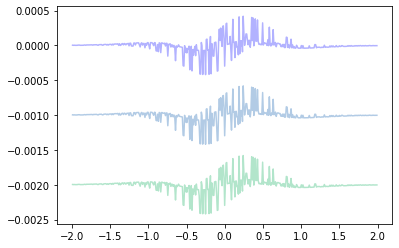

In [232]:
for trial_counter in range(N_trials):
#     plt.plot([w[1] for w in wtc if w[0]==0], 
#                  [w[2] +1e-3*trial_counter for w in wtc if w[0]==0],
#                  color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
# plt.plot([w[1] for w in wtc if w[0]==0], 
#              [d2_tanh(w[1])/-25+0*shift for w in wtc if w[0]==0],
#              color=[0.4,0,0])

trial 1/3, iter 0 of 241
trial 1/3, iter 8 of 241
trial 1/3, iter 16 of 241
trial 1/3, iter 24 of 241
trial 1/3, iter 32 of 241
trial 1/3, iter 40 of 241
trial 1/3, iter 48 of 241
trial 1/3, iter 56 of 241
trial 1/3, iter 64 of 241
trial 1/3, iter 72 of 241
trial 1/3, iter 80 of 241
trial 1/3, iter 88 of 241
trial 1/3, iter 96 of 241
trial 1/3, iter 104 of 241
trial 1/3, iter 112 of 241
trial 1/3, iter 120 of 241
trial 1/3, iter 128 of 241
trial 1/3, iter 136 of 241
trial 1/3, iter 144 of 241
trial 1/3, iter 152 of 241
trial 1/3, iter 160 of 241
trial 1/3, iter 168 of 241
trial 1/3, iter 176 of 241
trial 1/3, iter 184 of 241
trial 1/3, iter 192 of 241
trial 1/3, iter 200 of 241
trial 1/3, iter 208 of 241
trial 1/3, iter 216 of 241
trial 1/3, iter 224 of 241
trial 1/3, iter 232 of 241
trial 1/3, iter 240 of 241
trial 2/3, iter 0 of 241
trial 2/3, iter 8 of 241
trial 2/3, iter 16 of 241
trial 2/3, iter 24 of 241
trial 2/3, iter 32 of 241
trial 2/3, iter 40 of 241
trial 2/3, iter 48 of 24

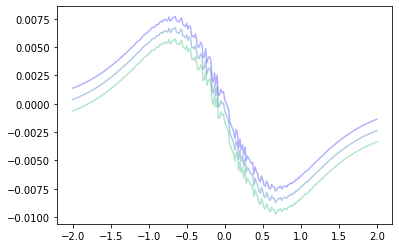

In [238]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,60)
N_trials = 3
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)
#plot_wtc(wtc, normz=True)
for trial_counter in range(N_trials):
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

trial 1/3, iter 0 of 481
trial 1/3, iter 10 of 481
trial 1/3, iter 20 of 481
trial 1/3, iter 30 of 481
trial 1/3, iter 40 of 481
trial 1/3, iter 50 of 481
trial 1/3, iter 60 of 481
trial 1/3, iter 70 of 481
trial 1/3, iter 80 of 481
trial 1/3, iter 90 of 481
trial 1/3, iter 100 of 481
trial 1/3, iter 110 of 481
trial 1/3, iter 120 of 481
trial 1/3, iter 130 of 481
trial 1/3, iter 140 of 481
trial 1/3, iter 150 of 481
trial 1/3, iter 160 of 481
trial 1/3, iter 170 of 481
trial 1/3, iter 180 of 481
trial 1/3, iter 190 of 481
trial 1/3, iter 200 of 481
trial 1/3, iter 210 of 481
trial 1/3, iter 220 of 481
trial 1/3, iter 230 of 481
trial 1/3, iter 240 of 481
trial 1/3, iter 250 of 481
trial 1/3, iter 260 of 481
trial 1/3, iter 270 of 481
trial 1/3, iter 280 of 481
trial 1/3, iter 290 of 481
trial 1/3, iter 300 of 481
trial 1/3, iter 310 of 481
trial 1/3, iter 320 of 481
trial 1/3, iter 330 of 481
trial 1/3, iter 340 of 481
trial 1/3, iter 350 of 481
trial 1/3, iter 360 of 481
trial 1/3, i

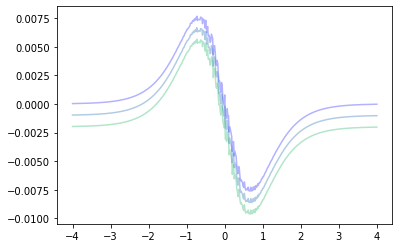

In [275]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-4,4,60)
N_trials = 3
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)
#plot_wtc(wtc, normz=True)
for trial_counter in range(N_trials):
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

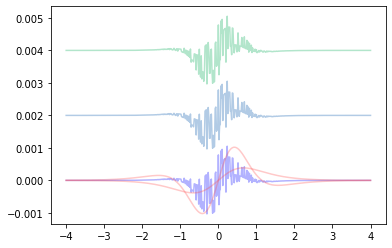

In [286]:
for trial_counter in range(N_trials):
#     plt.plot([w[1] for w in wtc if w[0]==0], 
#                  [w[2] -(d2_tanh(w[1])/-1+1e-7*trial_counter if normz else 0) for w in wtc if w[0]==0],
#                  color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
    plt.plot([w[1] for w in wtc if w[0]==0], 
                 [w[2]+d2_tanh(w[1])*0.06+1e-3*2*trial_counter for w in wtc if w[0]==0],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
plt.plot([w[1] for w in wtc if w[0]==0], 
                 [d4_tanh(w[1])/2000 for w in wtc if w[0]==0],
                 color=[1,.3,.3, 0.3])
plt.plot([w[1] for w in wtc if w[0]==0], 
                 [d2_tanh(w[1])/1000 for w in wtc if w[0]==0],
                 color=[1,.3,.3, 0.3])

trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


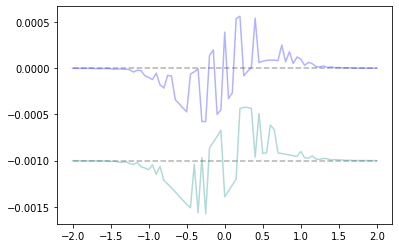

In [298]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)
#plot_wtc(wtc, normz=True)

for trial_counter in range(N_trials):
    plt.plot(bounds,[-1e-3*trial_counter,-1e-3*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25+1e-3*trial_counter if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

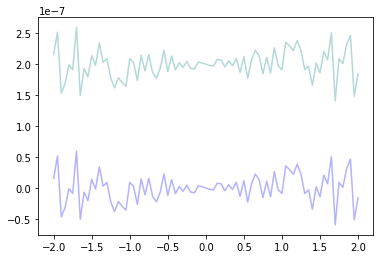

In [318]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=2)
#plot_wtc(wtc, normz=True)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000002*trial_counter+w[2] -1*(d2_tanh(w[1])/-50 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


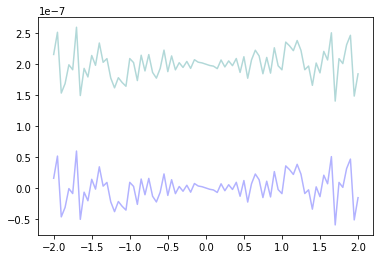

In [319]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc_alt=query_manual_model_wrapper(n_epochs=6)
# plot_wtc(wtc_alt)
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=3)
#plot_wtc(wtc, normz=True)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000002*trial_counter+w[2] -1*(d2_tanh(w[1])/-50 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])
print('change in weights = d2')

trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


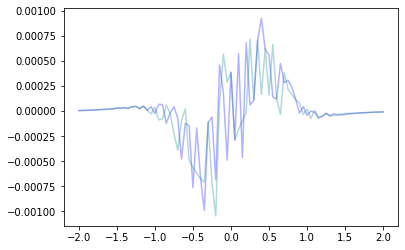

In [325]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000002*trial_counter+w[2] -1*(d2_tanh(w[1])*-0.06 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])


trial 1/2, iter 0 of 81
trial 1/2, iter 8 of 81
trial 1/2, iter 16 of 81
trial 1/2, iter 24 of 81
trial 1/2, iter 32 of 81
trial 1/2, iter 40 of 81
trial 1/2, iter 48 of 81
trial 1/2, iter 56 of 81
trial 1/2, iter 64 of 81
trial 1/2, iter 72 of 81
trial 1/2, iter 80 of 81
trial 2/2, iter 0 of 81
trial 2/2, iter 8 of 81
trial 2/2, iter 16 of 81
trial 2/2, iter 24 of 81
trial 2/2, iter 32 of 81
trial 2/2, iter 40 of 81
trial 2/2, iter 48 of 81
trial 2/2, iter 56 of 81
trial 2/2, iter 64 of 81
trial 2/2, iter 72 of 81
trial 2/2, iter 80 of 81
done


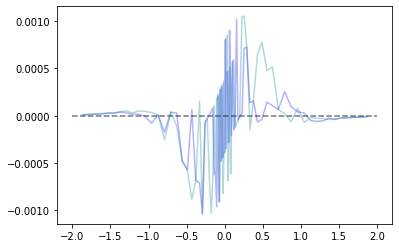

In [327]:
Y_data = [1,0,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-2,2,20)
N_trials = 2
# wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [.0000000*trial_counter+w[2] -1*(d2_tanh(w[1])*-0.06 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])


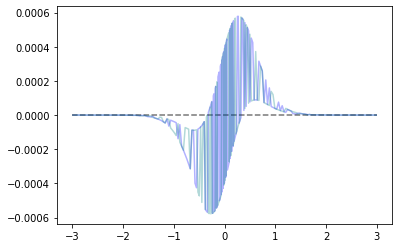

In [334]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 2
# wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/N_trials, 1-trial_counter/N_trials, 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


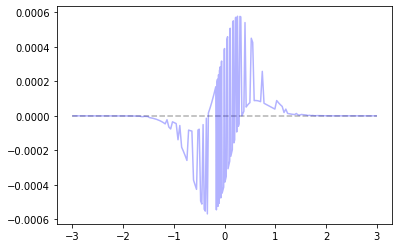

In [340]:
# verify....
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


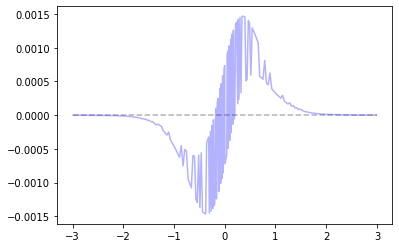

In [341]:
Y_data = [2,-2]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


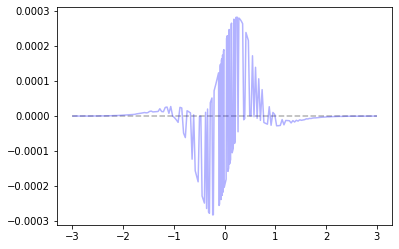

In [342]:
Y_data = [.5,-.5]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 241
trial 1/1, iter 24 of 241
trial 1/1, iter 48 of 241
trial 1/1, iter 72 of 241
trial 1/1, iter 96 of 241
trial 1/1, iter 120 of 241
trial 1/1, iter 144 of 241
trial 1/1, iter 168 of 241
trial 1/1, iter 192 of 241
trial 1/1, iter 216 of 241
trial 1/1, iter 240 of 241
done


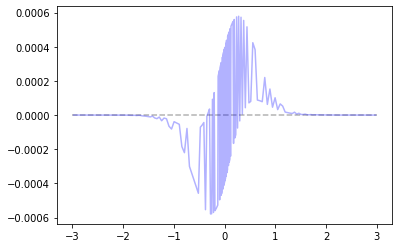

In [343]:
Y_data = [1,-1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
wtc=query_manual_model_wrapper(n_epochs=60, batchsize=1)

for trial_counter in range(N_trials):
#     plt.plot(bounds,[-1e-4*trial_counter,-1e-4*trial_counter], '--', color=[0,0,0,0.3])
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

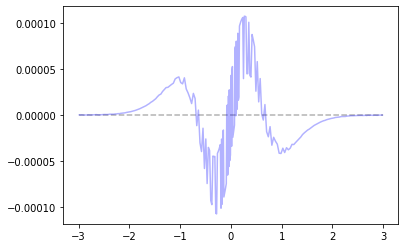

In [349]:
Y_data = [.1,-.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,40)
N_trials = 1
#wtc=query_manual_model_wrapper(n_epochs=30, batchsize=1)

normz=True

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] -(d2_tanh(w[1])/-25 if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

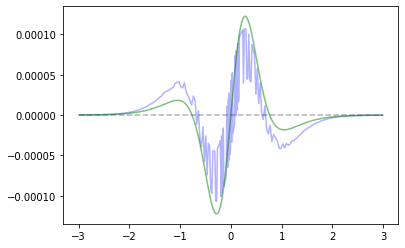

In [386]:
for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] + (d2_tanh(w[1])/25 - d4_tanh(w[1])*2.5e-15
                             if normz else 0) for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [d4_tanh(1.5*w[1])*6e-5 for w in wtc if w[0]==trial_counter],
                 color=[0, .5,0, 0.5])

trial 1/1, iter 0 of 421
trial 1/1, iter 25 of 421
trial 1/1, iter 50 of 421
trial 1/1, iter 75 of 421
trial 1/1, iter 100 of 421
trial 1/1, iter 125 of 421
trial 1/1, iter 150 of 421
trial 1/1, iter 175 of 421
trial 1/1, iter 200 of 421
trial 1/1, iter 225 of 421
trial 1/1, iter 250 of 421
trial 1/1, iter 275 of 421
trial 1/1, iter 300 of 421
trial 1/1, iter 325 of 421
trial 1/1, iter 350 of 421
trial 1/1, iter 375 of 421
trial 1/1, iter 400 of 421
done


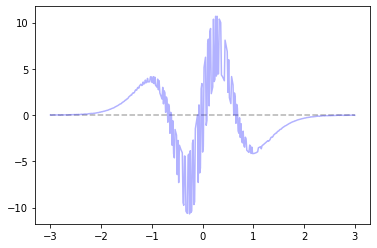

In [407]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e5 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

^^ alpha: ~0.33, gamma: ~0.73, delta: ~1

trial 1/1, iter 0 of 421
trial 1/1, iter 25 of 421
trial 1/1, iter 50 of 421
trial 1/1, iter 75 of 421
trial 1/1, iter 100 of 421
trial 1/1, iter 125 of 421
trial 1/1, iter 150 of 421
trial 1/1, iter 175 of 421
trial 1/1, iter 200 of 421
trial 1/1, iter 225 of 421
trial 1/1, iter 250 of 421
trial 1/1, iter 275 of 421
trial 1/1, iter 300 of 421
trial 1/1, iter 325 of 421
trial 1/1, iter 350 of 421
trial 1/1, iter 375 of 421
trial 1/1, iter 400 of 421
done


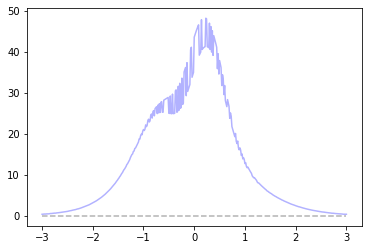

In [409]:
Y_data = [-.09,.11]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e5 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

trial 1/1, iter 0 of 421
trial 1/1, iter 25 of 421
trial 1/1, iter 50 of 421
trial 1/1, iter 75 of 421
trial 1/1, iter 100 of 421
trial 1/1, iter 125 of 421
trial 1/1, iter 150 of 421
trial 1/1, iter 175 of 421
trial 1/1, iter 200 of 421
trial 1/1, iter 225 of 421
trial 1/1, iter 250 of 421
trial 1/1, iter 275 of 421
trial 1/1, iter 300 of 421
trial 1/1, iter 325 of 421
trial 1/1, iter 350 of 421
trial 1/1, iter 375 of 421
trial 1/1, iter 400 of 421
done


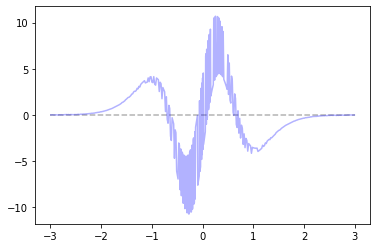

In [410]:
Y_data = [-.1,.1]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
wtc=query_manual_model_wrapper(n_epochs=20, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

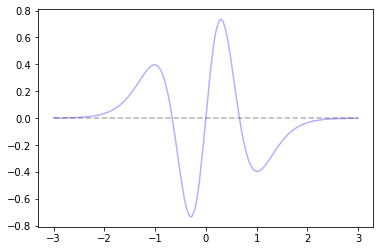

In [413]:
Y_data = [-.001,.001]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-3,3,70)
N_trials = 1
normz=True
#wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)


for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [(w[2] -(d2_tanh(w[1])/-25 if normz else 0))*1e4 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

^ 12.5/40 pixels, 27/40 pixels, 41/40 pixels are alpha/gamma/delta. Alpha peak is 42 vs delta's 79 = 1.881x difference.

Off of this, I investigated:
d4_alt(x,s) = d2(x,s) * d/dx d2(x,s)
            = (s(x) d/dx s(x)) * d/dx (s(x) d/dx s(x))
            = tanh(x) sech^2(x) (sech^4(x) - 2 tanh^2(x) sech^2(x)) if s=tanh
This yields alpha/gamma/delta: 0.293, 0.658, 1.008 , = 11.7/40, 26.3/40, 40.3/40 which is probably a match, then.

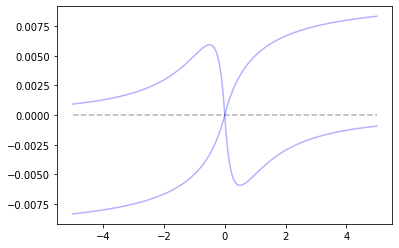

In [427]:
Y_data = [-.01,.01]
X_data = [ np.ones((1,)) for v in Y_data ]     # x_counter
Weights, bounds = weights_range(-5,5,40)
N_trials = 1
normz=True
Nonlinearity= ('softsign',  tf.keras.activations.softsign )
# wtc=query_manual_model_wrapper(n_epochs=1, batchsize=1)

def softsign(x): return x/(1+abs(x))
def d2_softsign(x): return x/(1+abs(x))**3

for trial_counter in range(N_trials):
    plt.plot(bounds,[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[2] for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])
plt.plot([w[1] for w in wtc if w[0]==trial_counter], 
                 [w[1]/(1+abs(w[1]))*1e-2 for w in wtc if w[0]==trial_counter],
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])

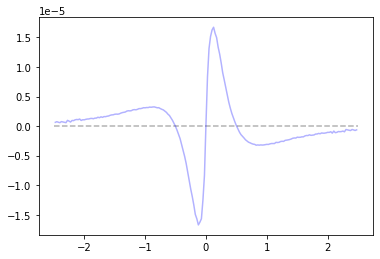

In [439]:
for trial_counter in range(N_trials):
    plt.plot([-2.5,2.5],[0,0], '--', color=[0,0,0,0.3])
    plt.plot([w[1] for w in wtc if w[0]==trial_counter and abs(w[1])<2.5], 
                 [w[2]-d2_softsign(-w[1])*4e-2 for w in wtc if w[0]==trial_counter and abs(w[1])<2.5] ,
                 color=[0, trial_counter/(N_trials), 1-trial_counter/(N_trials), 0.3])


^ 7/49=0.143, 26/49=0.531, 43/49=0.878.
Original D4, d/dx d/dx ( s(x) * d/dx s(x) ) is discontinuous at 0.
Modified D4, (s(x)*d/dx s(x))*d/dx(s(x)*d/dx s(x)), has alpha/gamma/delta at 0.113, 0.5, 0.887 where the peak at alpha is about 5.5 times greater than the delta peak, and unlike modified D4 whose analytic alpha is 1.830 times greater than the delta peak. 